In [414]:
import torch
device = 'cuda'
print(device)

cuda


In [415]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms


In [416]:
from six.moves import urllib    
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [417]:
num_workers = 0
batch_size = 32
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data',train=True,download=True,transform=transform)
train_loader = DataLoader(train_data,batch_size=batch_size,num_workers=num_workers,shuffle=True)
test_data = datasets.MNIST(root='data',train=False,download=True,transform=transform)
test_loader = DataLoader(test_data,batch_size=batch_size,num_workers=num_workers)


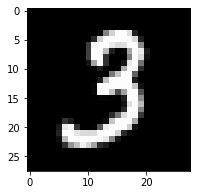

In [418]:
import numpy as np
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images,labels = dataiter.next()
images = images.numpy()

img =np.squeeze(images[0])
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')

NOISE GENERATION

In [419]:
def random_noise_generator(batch_size,dim):
  return torch.rand(batch_size,dim)*2-1

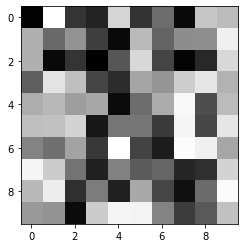

In [420]:
a = random_noise_generator(64,100)
b = a[2]
b = b.reshape(10,10)
b = b.numpy()
plt.imshow(b,cmap='gray')

# **Discriminator**

In [421]:


class Discriminator(nn.Module):
    
  def __init__(self):
    super().__init__()
    self.conv0 = nn.Conv2d(1, 32, kernel_size = 3, stride = 2, padding = 1)
    self.conv0_bn = nn.BatchNorm2d(32)
    self.conv0_drop = nn.Dropout2d(0.25)
    self.conv1 = nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1)
    self.conv1_bn = nn.BatchNorm2d(64)
    self.conv1_drop = nn.Dropout2d(0.25)
    self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1)
    self.conv2_bn = nn.BatchNorm2d(128)
    self.conv2_drop = nn.Dropout2d(0.25)
    self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1)
    self.conv3_bn = nn.BatchNorm2d(256)
    self.conv3_drop = nn.Dropout2d(0.25)
    self.fc = nn.Linear(12544, 1)

  def forward(self, x):
    x = x.view(-1, 1, 28, 28)
    x = F.leaky_relu(self.conv0(x), 0.2)
    x = self.conv0_bn(x)
    x = self.conv0_drop(x)
    x = F.leaky_relu(self.conv1(x), 0.2)
    x = self.conv1_bn(x)
    x = self.conv1_drop(x)
    x = F.leaky_relu(self.conv2(x), 0.2)
    x = self.conv2_bn(x)
    x = self.conv2_drop(x)
    x = F.leaky_relu(self.conv3(x), 0.2)
    x = self.conv3_bn(x)
    x = self.conv3_drop(x)
    x = x.view(-1, self.num_flat_features(x))
    x = self.fc(x)
    
    return x
  
  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for s in size:
        num_features *= s
    
    return num_features

In [422]:

class Generator(nn.Module):
    
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(100, 256*7*7)
    self.trans_conv1 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)
    self.trans_conv1_bn = nn.BatchNorm2d(128)
    self.trans_conv2 = nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 1, padding = 1)
    self.trans_conv2_bn = nn.BatchNorm2d(64)
    self.trans_conv3 = nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 1, padding = 1)
    self.trans_conv3_bn = nn.BatchNorm2d(32)
    self.trans_conv4 = nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 2, padding = 1, output_padding = 1)

  def forward(self, x):
    x = self.fc(x)
    x = x.view(-1, 256, 7, 7)
    x = F.relu(self.trans_conv1(x))
    x = self.trans_conv1_bn(x)
    x = F.relu(self.trans_conv2(x))
    x = self.trans_conv2_bn(x)
    x = F.relu(self.trans_conv3(x))
    x = self.trans_conv3_bn(x)
    x = self.trans_conv4(x)
    x = torch.tanh(x)
    
    return x       



In [423]:
D = Discriminator()
G  = Generator()

print(D)
print(G)
D = D.to(device)
G = G.to(device)

D = D.float()
G = G.float()

Discriminator(
  (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv0_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv0_drop): Dropout2d(p=0.25, inplace=False)
  (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_drop): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_drop): Dropout2d(p=0.25, inplace=False)
  (fc): Linear(in_features=12544, out_features=1, bias=True)
)
Generator(
  (fc): Linear(in_features=

In [424]:
Loss = nn.BCEWithLogitsLoss()

def discriminator_real_loss(real_out):
  real_label = torch.ones(real_out.size()[0],1).to(device)

  real_loss = Loss(real_out.squeeze(),real_label.squeeze())

  return real_loss

def discriminator_fake_loss(fake_out):
  fake_label = torch.zeros(fake_out.size()[0],1).to(device)

  fake_loss = Loss(fake_out.squeeze(),fake_label.squeeze())

  return fake_loss

def discriminator_loss(real_out,fake_out):
  real_loss = discriminator_real_loss(real_out)
  fake_loss = discriminator_fake_loss(fake_out)
  total_loss = (real_loss+fake_loss)

  return total_loss

In [425]:
def generator_loss(gen_disc_out):

  label = torch.ones(gen_disc_out.size()[0],1).to(device)
  gen_loss = Loss(gen_disc_out.squeeze(),label.squeeze())

  return gen_loss

In [426]:
disc_opt = optim.Adam(D.parameters(),lr = 0.0002,betas =(0.5,0.999))
gen_opt = optim.Adam(G.parameters(),lr = 0.0002,betas =(0.5,0.999))

In [427]:
def train(D,G,disc_opt,gen_opt,train_loader,batch_size=32,epochs=25,gen_input_size=100):

  disc_losses = []
  gen_losses = []

  sample_size = 16

  fixed_samples = random_noise_generator(sample_size,gen_input_size)
  fixed_samples = fixed_samples.to(device)

  D.train()
  G.train()

  for epoch in range(epochs+1):
    

    disc_loss_total =0
    gen_loss_total =0
    gen_out = 0

    for batch_i,(train_x,_) in enumerate(train_loader):

      disc_opt.zero_grad()
      
      train_x = train_x*2-1
      train_x = train_x.to(device)
      real_out = D(train_x.float())

      disc_gen_in = random_noise_generator(batch_size,gen_input_size)
      disc_gen_in = disc_gen_in.to(device)

      disc_gen_out = G(disc_gen_in.float()).detach()

      fake_out = D(disc_gen_out.float())

      disc_loss = discriminator_loss(real_out,fake_out)

      disc_loss_total +=disc_loss

      disc_loss.backward()
      disc_opt.step()

      gen_opt.zero_grad()

      gen_out = G(disc_gen_in.float())
      gen_disc_out = D(gen_out.float())

      gen_loss = generator_loss(gen_disc_out)

      gen_loss_total += gen_loss

      gen_loss.backward()
      gen_opt.step()

    disc_losses.append(disc_loss_total)
    gen_losses.append(gen_loss_total)

    if epochs%5 ==0:
      G.eval()

      samples = G(fixed_samples.float())
      G.train()

      fig,axes = plt.subplots(figsize=(7,7),nrows=4,ncols=4,sharey=True,sharex=True)

      for ax,img in zip(axes.flatten(),samples):

        img = img.cpu().detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        im = ax.imshow(img.reshape((28,28)),cmap='Greys_r')

    print("Epoch ",epoch, ":Discriminator Loss = ",disc_loss_total/len(train_loader),", Generator Loss = ",gen_loss_total/len(train_loader))

  return disc_losses,gen_losses



Epoch  0 :Discriminator Loss =  tensor(0.6963, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(2.7505, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  1 :Discriminator Loss =  tensor(1.0533, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.6013, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  2 :Discriminator Loss =  tensor(1.0881, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.5286, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  3 :Discriminator Loss =  tensor(1.0884, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.5201, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  4 :Discriminator Loss =  tensor(1.0200, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.6219, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  5 :Discriminator Loss =  tensor(0.9645, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(1.7450, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  6 :Discri

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch  20 :Discriminator Loss =  tensor(0.7136, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(2.5341, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  21 :Discriminator Loss =  tensor(0.6936, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(2.5702, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  22 :Discriminator Loss =  tensor(0.6687, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(2.6130, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  23 :Discriminator Loss =  tensor(0.6773, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(2.6674, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  24 :Discriminator Loss =  tensor(0.6913, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(2.6128, device='cuda:0', grad_fn=<DivBackward0>)
Epoch  25 :Discriminator Loss =  tensor(0.6521, device='cuda:0', grad_fn=<DivBackward0>) , Generator Loss =  tensor(2.7097, device='cuda:0', grad_fn=<DivBackward0>)


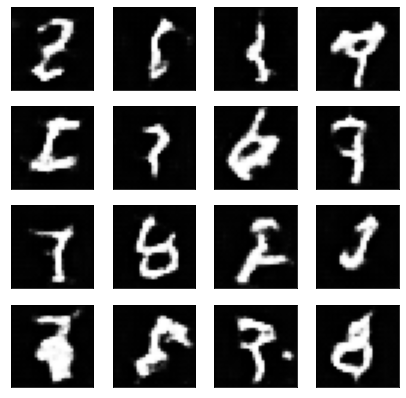

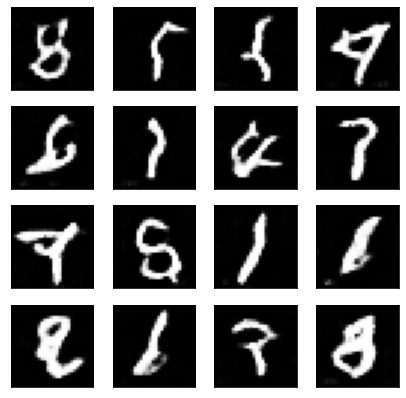

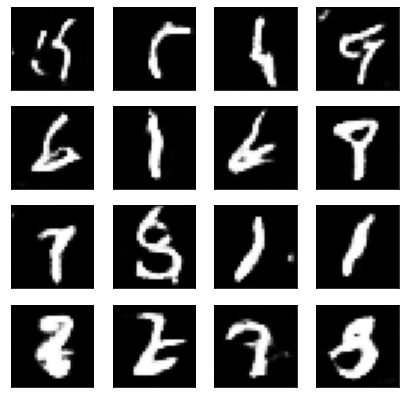

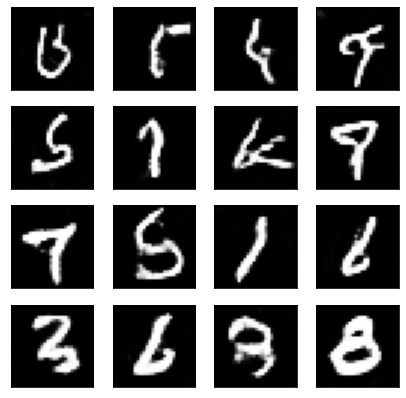

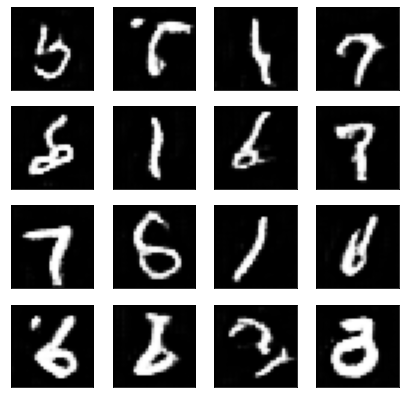

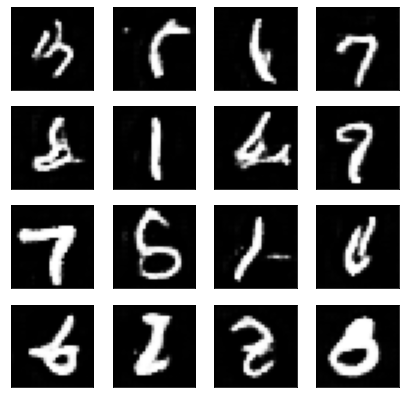

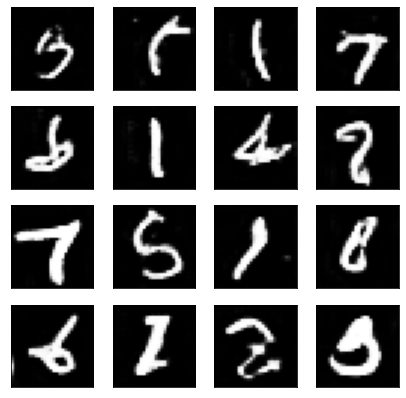

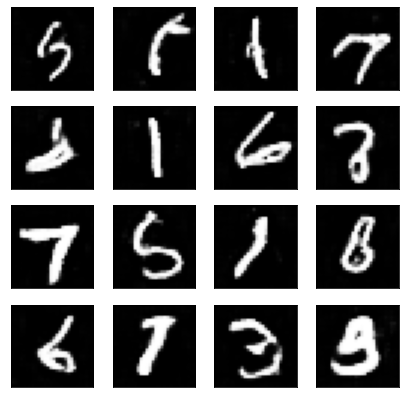

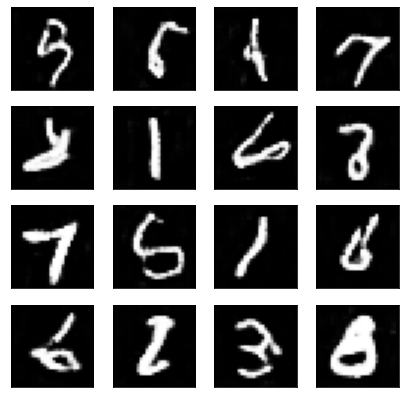

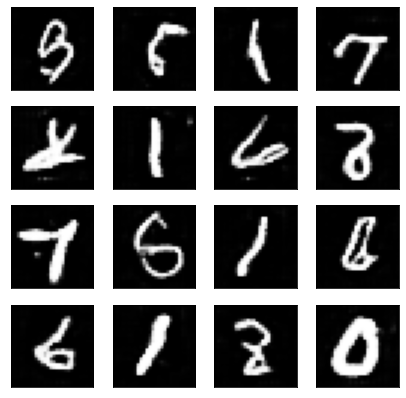

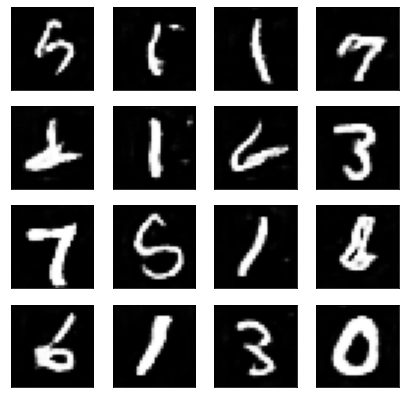

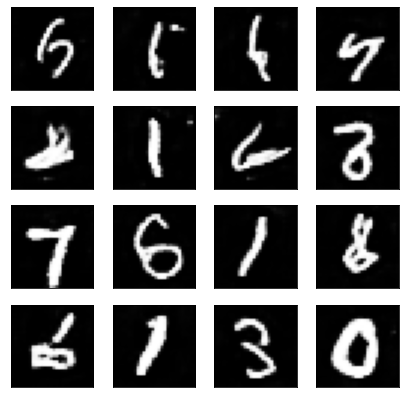

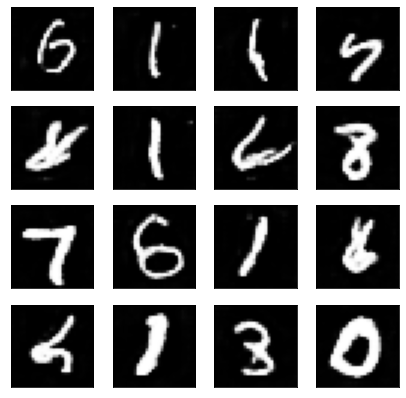

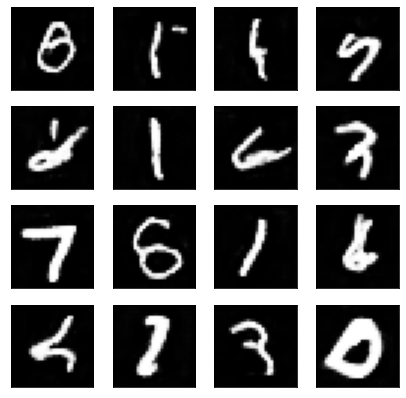

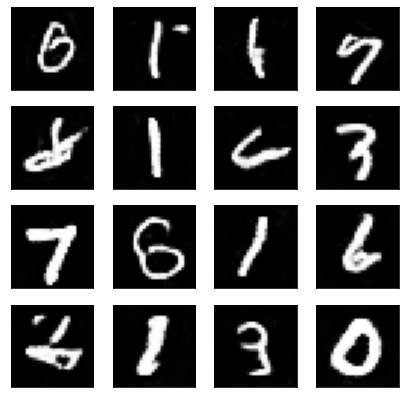

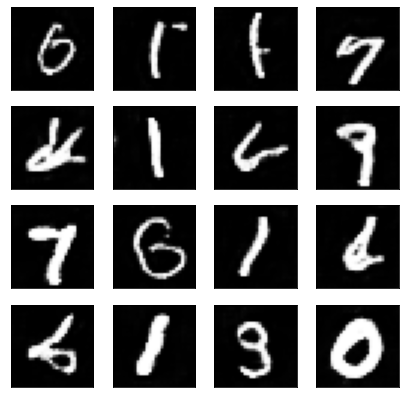

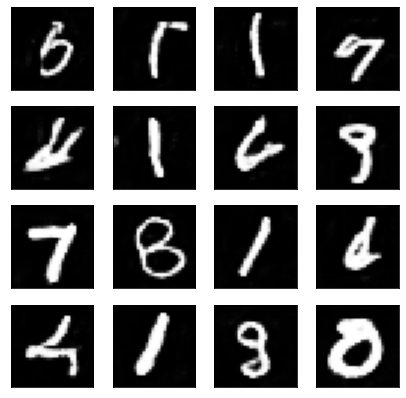

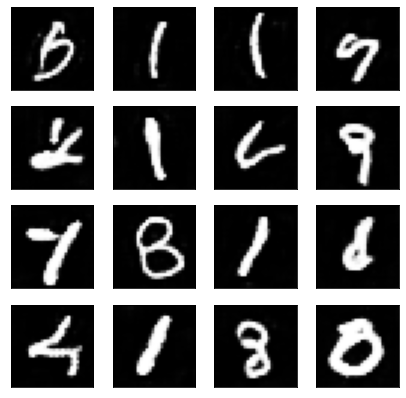

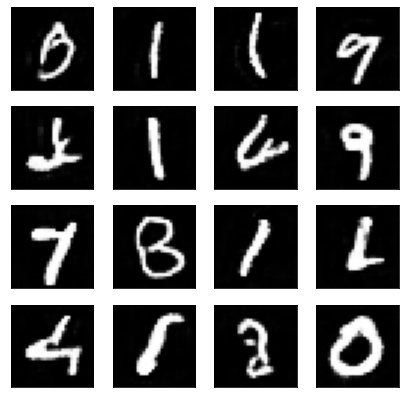

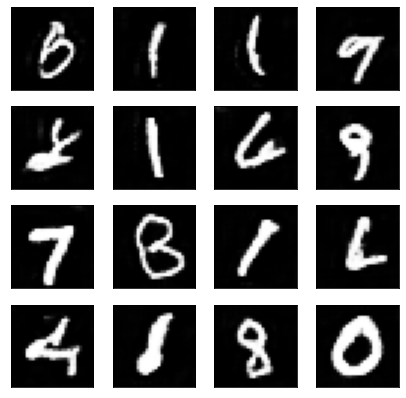

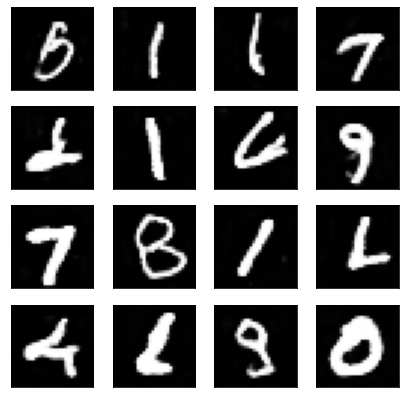

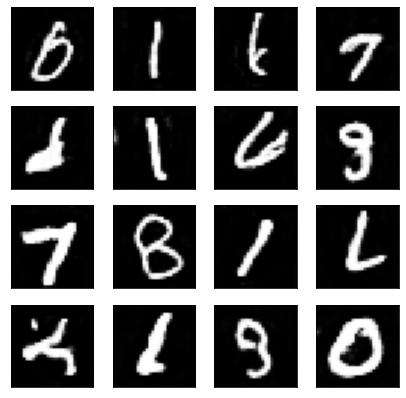

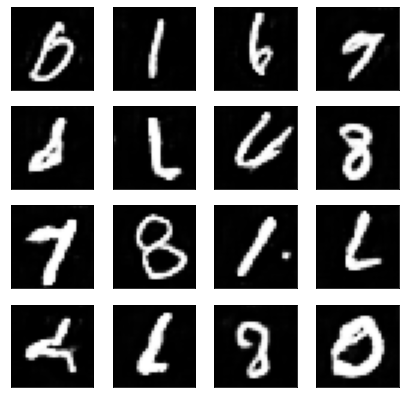

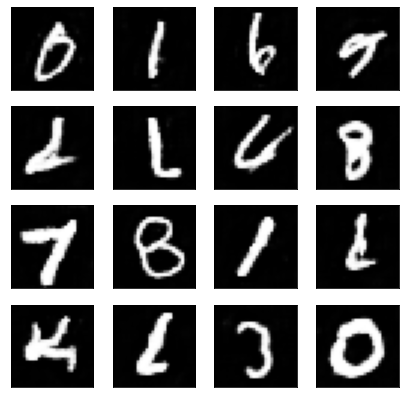

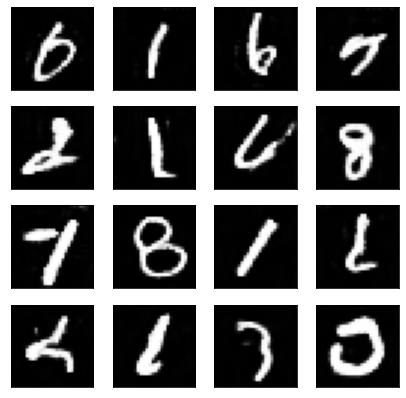

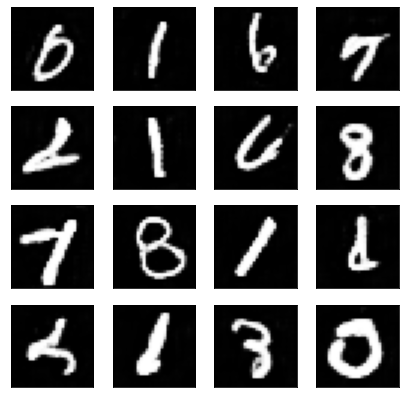

In [428]:
disc_losses,gen_losses = train(D,G,disc_opt,gen_opt,train_loader,batch_size)

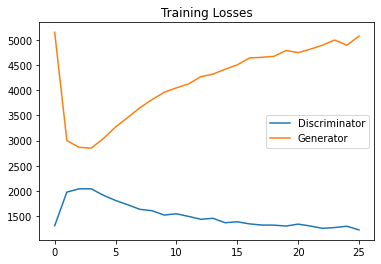

In [429]:


fig, ax = plt.subplots()
disc_losses = np.array(disc_losses)
gen_losses = np.array(gen_losses)
plt.plot(disc_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.title("Training Losses")
plt.legend()

